## Deezer

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessing.preprocessing import *
from training.cv_split import train_split_2
from collaborative_filtering.baseline_cf import BaselineCF
from collaborative_filtering.ALS_func import convert_rdd, compute_y_pred

from pyspark import SparkConf, SparkContext
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.linalg.distributed import RowMatrix

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from hyperopt import STATUS_OK, hp, fmin, tpe, Trials, space_eval

from time import time

from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

random_seed = 8

In [4]:
full_preprocessing(train)
full_preprocessing(test)

In [5]:
submitting = False

if not submitting:
    train = train[:1000000]
    
    # Nb of songs in the test set for each user
    nb_songs = 10
    train_f , test_f = train_split_2(train, nb_songs)

### Baseline CF

In [6]:
baseline_CF = BaselineCF()

baseline_CF.fit(train_f)

validation_score = roc_auc_score(test_f['is_listened'], baseline_CF.predict(test_f))
print('Validation score: {0}'.format(validation_score))

train_score = roc_auc_score(train_f['is_listened'], 
                            baseline_CF.predict(train_f))
print('Training score: {0}'.format(train_score))

Validation score: 0.735716091076
Training score: 0.820380850078


## Low rank matrix factorisation

In [7]:
# Spark parameters
conf = SparkConf().set("spark.executor.memory", "2g")
sc = SparkContext(conf=conf)

if (submitting):
    train_f = train.copy()
train = []

In [8]:
item_id = 'media_id'
user_mean_dict = train_f.groupby('user_id')['is_listened'].mean().to_dict()
item_mean_dict = train_f.groupby(item_id)['is_listened'].mean().to_dict()

implicit = False

if (implicit):
    train_f_2 = train_f.copy()
    train_f_2.loc[train_f_2['is_listened'] == 0, 'is_listened'] = -1
    train_f_agg = train_f_2.groupby(['user_id', item_id])['is_listened'].sum().reset_index()
    train_f_2 = []
else:
    # Group by mean of 'is_listened' of the same songs listened by the same users
    # Note that spark automatically takes the mean when given 
    # duplicate (user_id, item_id) pairs
    train_f_agg = train_f.groupby(['user_id', item_id])['is_listened'].mean().reset_index()

if (submitting):
    test_f = test.copy()
    # Need a column 'is_listened' in convert_rdd
    test_f['is_listened'] = 0
test = []


iterations = 20
rank = 20

train_f_rdd = convert_rdd(train_f_agg, sc, item_id=item_id)
test_f_rdd = convert_rdd(test_f, sc, item_id=item_id)

if (implicit):
    lmbda = 0.01
    alpha = 50.
    model = ALS.trainImplicit(train_f_rdd, rank=rank,
                              iterations=iterations, lambda_=lmbda, 
                              alpha=alpha, seed=random_seed)
else:
    lmbda = 0.01
    model = ALS.train(train_f_rdd, rank=rank,
                      iterations=iterations, lambda_=lmbda, 
                      seed=random_seed)

print('{0} users'.format(model.userFeatures().count()))
print('{0} items'.format(model.productFeatures().count()))

17710 users
46352 items


In [9]:
# Test data without its last element for predictAll
test_f_rdd_X = test_f_rdd.map(lambda r: (r[0], r[1]))
predictions = model.predictAll(test_f_rdd_X).map(lambda r: ((r[0], r[1]), r[2]))

# Prediction with ALS
test_f_pred = compute_y_pred(test_f, predictions, item_id, user_mean_dict)

if not (submitting):
    print(roc_auc_score(test_f_pred['is_listened'], test_f_pred['is_listened_pred']))

0.695402986348


In [10]:
user_features = np.asarray(model.userFeatures().map(lambda r: r[1]).collect())
print(user_features.shape)

item_features = np.asarray(model.productFeatures().map(lambda r: r[1]).collect())
print(item_features.shape)

user_id_list = np.asarray(model.userFeatures().map(lambda r: r[0]).collect())
item_id_list = np.asarray(model.productFeatures().map(lambda r: r[0]).collect())

sc.stop()

(17710, 20)
(46352, 20)


## Incorporating user/media preferences

In [11]:
global_baseline = train_f['is_listened'].mean()

def compute_means(X, user_mean_dict, item_mean_dict, item_id, global_baseline):
    X['user_mean'] = X['user_id'].map(user_mean_dict).fillna(global_baseline)
    column_name = item_id[:len(item_id) - len('id')] + 'mean'
    X[column_name] = X[item_id].map(item_mean_dict).fillna(global_baseline)

compute_means(train_f, user_mean_dict, item_mean_dict, item_id, global_baseline)
compute_means(test_f, user_mean_dict, item_mean_dict, item_id, global_baseline)

def user_latent_features(X, user_features, user_id_list):
    # Number of latent features
    p = user_features.shape[1]
    
    for i in range(p):
        l_feature_dict = dict(zip(user_id_list, user_features[:, i]))
        X['latent_user_' + str(i)] = X['user_id'].map(l_feature_dict).fillna(0)

user_latent_features(train_f, user_features, user_id_list)
user_latent_features(test_f, user_features, user_id_list)

def item_latent_features(X, item_features, item_id_list, item_id):
    # Number of latent features
    p = item_features.shape[1]
    
    for i in range(p):
        l_feature_dict = dict(zip(item_id_list, item_features[:, i]))
        X['latent_item_' + str(i)] = X[item_id].map(l_feature_dict).fillna(0)

#item_latent_features(train_f, item_features, item_id_list, item_id)
#item_latent_features(test_f, item_features, item_id_list, item_id)

In [12]:
# Create rank of item_id, in [0, n_items[. 0 for highly popular songs
item_id_df = pd.concat([train_f, test_f]).groupby(item_id)['ts_listen'].count().reset_index()
item_id_df.sort_values(by='ts_listen', ascending=False, inplace=True)
n_items = item_id_df.shape[0]
item_id_dict = dict(zip(item_id_df[item_id].values, np.arange(n_items, dtype=int)))

train_f['item_rank'] = train_f[item_id].map(item_id_dict)
test_f['item_rank'] = test_f[item_id].map(item_id_dict)

In [13]:
cols_excluded = (['ts_listen', 'media_id', 'album_id', 'release_date',
                 'artist_id', 'ts_listen_fmt', 'is_listened', 'index',
                 'release_date_year', 'release_date_month',
                 'release_date_day', 'media_duration_categ']
                )
cols = [c for c in train_f.columns if c not in cols_excluded]

train_f_flow = train_f[train_f['listen_type'] == 1]
train_size = train_f_flow.shape[0]
print(train_f_flow.shape)
print(cols)

(198203, 48)
['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration', 'listen_type', 'user_gender', 'user_id', 'user_age', 'year_listen', 'month_listen', 'day_listen', 'hour_listen', 'user_mean', 'media_mean', 'latent_user_0', 'latent_user_1', 'latent_user_2', 'latent_user_3', 'latent_user_4', 'latent_user_5', 'latent_user_6', 'latent_user_7', 'latent_user_8', 'latent_user_9', 'latent_user_10', 'latent_user_11', 'latent_user_12', 'latent_user_13', 'latent_user_14', 'latent_user_15', 'latent_user_16', 'latent_user_17', 'latent_user_18', 'latent_user_19', 'item_rank']


In [14]:
# Merge data to standardise them
merged_df = pd.concat([train_f_flow, test_f])
merged_df.loc[:, cols] = scale(merged_df[cols])

# Split data
train_f_flow = merged_df[:train_size]
test_f = merged_df[train_size:]

In [15]:
########
## RFC
########
min_samples_leaf_grid = [5]
nb_trees = 100
max_depth = 15

for min_samples_leaf in min_samples_leaf_grid:
    print('Max depth: {0}'.format(max_depth))
    print('Min samples leaf: {0}'.format(min_samples_leaf))
    
    rfc = RandomForestClassifier(n_estimators=nb_trees,
                                 max_depth=max_depth, 
                                 min_samples_leaf= min_samples_leaf,
                                 random_state=random_seed)

    rfc.fit(train_f_flow[cols], train_f_flow['is_listened'])
        
    score = roc_auc_score(test_f['is_listened'], 
                          rfc.predict_proba(test_f[cols])[:, 1])
    print('Validation score: {0}'.format(score))

    # Training AUC
    train_score = roc_auc_score(train_f_flow['is_listened'], 
                                rfc.predict_proba(train_f_flow[cols])[:, 1])
    print('Training score: {0}\n'.format(train_score))

Max depth: 15
Min samples leaf: 5
Validation score: 0.769975079159
Training score: 0.914078315502



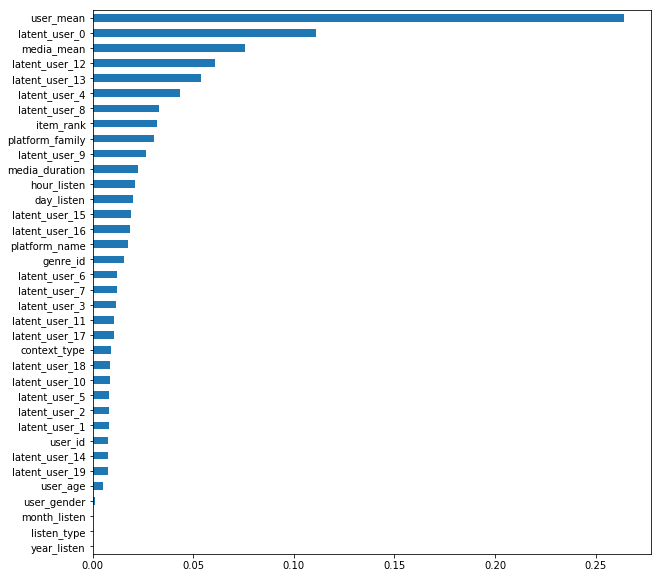

In [16]:
features_plot = pd.Series(rfc.feature_importances_, index=cols)
features_plot.sort_values(inplace=True)
features_plot.plot(kind='barh', figsize=(10, 10))

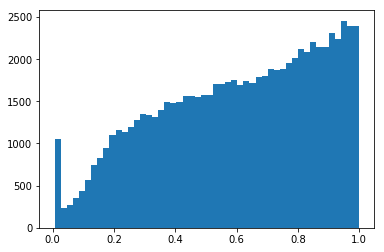

In [17]:
y_pred_rfc = rfc.predict_proba(test_f[cols])[:, 1]
plt.hist(y_pred_rfc, bins=50)
plt.show()

In [18]:
########
## XGB
########
nb_trees = 100
early_stopping_rounds = 10

# Scoring function in the hyperopt hyperparameters tuning.
def scoring_function(parameters):
    print("Training the model with parameters: ")
    print(parameters)

    D_train = xgb.DMatrix(train_f_flow[cols], label=train_f_flow['is_listened'])
    D_validation = xgb.DMatrix(test_f[cols], label=test_f['is_listened'])

    watchlist = [(D_train, 'Training'), (D_validation, 'Validation')]
    xgb_model = xgb.train(parameters, D_train, nb_trees, watchlist, 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=10, maximize=True)

    y_predict = xgb_model.predict(D_validation, ntree_limit=xgb_model.best_iteration)
        
    score = roc_auc_score(test_f['is_listened'], y_predict)

    print("Cross-validation score: {0}".format(score))
    
    return {"loss": 1 - score, "status": STATUS_OK}

In [19]:
t0 = time()

# Grid to pick parameters from.
parameters_grid = {"eta": hp.choice("eta", np.array([0.03])),
                   "max_depth": hp.choice("max_depth", np.array([15], dtype=int)),
                   #"subsample": hp.choice("subsample", np.array([0.8])),
                   "lambda": hp.choice("lambda", np.array([22])),
                   "objective": "binary:logistic",
                   "eval_metric": "auc",
                   "silent": 0,
                   "seed": random_seed
                  }
# Record the information about the cross-validation.
trials = Trials()

best = fmin(scoring_function, parameters_grid, algo=tpe.suggest, max_evals=1, 
            trials=trials) 

print('Computing time: {0}s'.format(time() - t0))

Training the model with parameters: 
{'eta': 0.029999999999999999, 'silent': 0, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 8, 'max_depth': 15, 'lambda': 22}
[0]	Training-auc:0.867868	Validation-auc:0.734228
Multiple eval metrics have been passed: 'Validation-auc' will be used for early stopping.

Will train until Validation-auc hasn't improved in 10 rounds.
[10]	Training-auc:0.87945	Validation-auc:0.74318
[20]	Training-auc:0.884691	Validation-auc:0.745553
[30]	Training-auc:0.889492	Validation-auc:0.746757
[40]	Training-auc:0.894083	Validation-auc:0.748116
[50]	Training-auc:0.898439	Validation-auc:0.748999
[60]	Training-auc:0.902185	Validation-auc:0.749635
[70]	Training-auc:0.905752	Validation-auc:0.749979
[80]	Training-auc:0.908897	Validation-auc:0.750584
[90]	Training-auc:0.911841	Validation-auc:0.751401
[99]	Training-auc:0.9145	Validation-auc:0.752009
Cross-validation score: 0.751949158079
Computing time: 70.7278761864s


In [20]:
nb_trees = 100
parameters = {"eta": 0.03,
              "max_depth": 15,
              "lambda": 22,
              "objective": "binary:logistic",
              "eval_metric": "auc",
              "silent": 0,
              "seed": random_seed
              }

D_train = xgb.DMatrix(train_f_flow[cols], label=train_f_flow['is_listened'])
D_validation = xgb.DMatrix(test_f[cols], label=test_f['is_listened'])

xgb_model = xgb.train(parameters, D_train, nb_trees)

y_pred_xgb = xgb_model.predict(D_validation)
        
roc_auc_score(test_f['is_listened'], y_pred_xgb)

0.75200873284308134

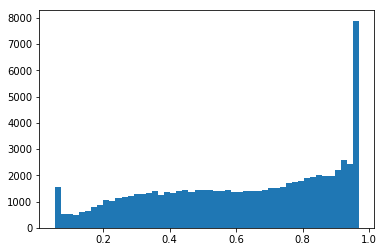

In [21]:
plt.hist(y_pred_xgb, bins=50)
plt.show()

### Keras

In [22]:
layer1_grid = [10]
dropout = 0.2
epochs_grid = [100]

scores = []

for layer1 in layer1_grid:
    for epochs in epochs_grid:
        print('Layer 1: {0}'.format(layer1))
        print('Dropout rate: {0}'.format(dropout))
        print('Number of epochs: {0}'.format(epochs))
        
        dnn = Sequential()
        dnn.add(Dense(layer1, activation='relu', input_shape=(len(cols),)))
        dnn.add(Dropout(dropout))
        dnn.add(Dense(1, activation='sigmoid'))
        dnn.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

        dnn.fit(train_f_flow[cols].values, train_f_flow['is_listened'].values,
                epochs=epochs, batch_size=128, verbose=0)

        score = roc_auc_score(test_f['is_listened'], dnn.predict(test_f[cols].values)[:, 0])
        scores.append(score)
        print('Validation score: {0}'.format(score))

        training_score = roc_auc_score(train_f_flow['is_listened'], dnn.predict(train_f_flow[cols].values)[:, 0])
        print('Training score: {0}\n'.format(training_score))

y_pred_dnn = dnn.predict(test_f[cols].values)[:, 0]

Layer 1: 10
Dropout rate: 0.2
Number of epochs: 100
Validation score: 0.750021765706
Training score: 0.856407145019



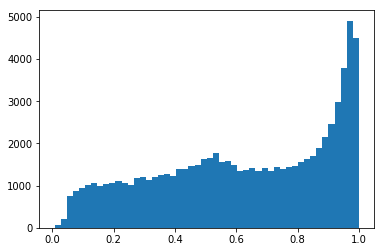

In [23]:
plt.hist(y_pred_dnn, bins=50)
plt.show()

### Predicting

In [12]:
t0 = time()

print('Training RFC...')
########
## RFC
########
nb_trees = 100
max_depth = 15
min_samples_leaf = 5

rfc = RandomForestClassifier(n_estimators=nb_trees,
                             max_depth=max_depth,
                             min_samples_leaf=min_samples_leaf,
                             random_state=random_seed)

rfc.fit(train_f_flow[cols], train_f_flow['is_listened'])
        
y_pred_rfc = rfc.predict_proba(test_f[cols])[:, 1]

print('Finished RFC\n')
print('Training Xgboost...')

########
## XGB
########
nb_trees = 100
parameters = {"eta": 0.03,
              "max_depth": 15,
              "lambda": 10,
              "objective": "binary:logistic",
              "eval_metric": "auc",
              "silent": 0,
              "seed": random_seed
              }

D_train = xgb.DMatrix(train_f_flow[cols], label=train_f_flow['is_listened'])
D_validation = xgb.DMatrix(test_f[cols], label=test_f['is_listened'])

xgb_model = xgb.train(parameters, D_train, nb_trees)

y_pred_xgb = xgb_model.predict(D_validation)

print('Finished Xgboost\n')

Training RFC...
Finished RFC

Training Xgboost...
Finished Xgboost



In [13]:
rfc_weight = 0.5
y_pred_combined = rfc_weight * y_pred_rfc + (1 - rfc_weight) * y_pred_xgb

In [14]:
test_f['is_listened'] = y_pred_combined 

test_f[['sample_id', 'is_listened']].to_csv('RFC_depth_15_samples_5_xgb_weight05_implicit.csv',
                                            index=False)